In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
sc.set_figure_params(dpi=300, frameon=False)
sc.logging.print_header()

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.2 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.23.2 statsmodels==0.11.1 python-igraph==0.8.3 leidenalg==0.8.3


In [2]:
%load_ext autoreload
%autoreload 2

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
adata = sc.read('datasets/lincs.h5ad')
sciplex = sc.read('datasets/sciplex3_old_reproduced.h5ad')

## Load model

In [4]:
import torch
from compert.train import prepare_compert

state, args, history = torch.load(
    'sweep_lincs_logsigm_model_seed=61_epoch=180.pt',
    map_location=torch.device('cpu'))

# load the dataset and model pre-trained weights
model, datasets = prepare_compert(args, state_dict=state)

In [5]:
args

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'dataset_path': 'datasets/lincs.h5ad',
 'perturbation_key': 'condition',
 'dose_key': 'dose_val',
 'cell_type_key': 'cell_type',
 'split_key': 'split',
 'loss_ae': 'gauss',
 'doser_type': 'logsigm',
 'decoder_activation': 'linear',
 'seed': 61,
 'hparams': '',
 'max_epochs': 2000,
 'max_minutes': 3000,
 'patience': 20,
 'checkpoint_freq': 20,
 'save_dir': '/checkpoint/dlp/sweep_lincs_logsigm',
 'sweep_seeds': 200}

In [6]:
model.hparams

{'dim': 512,
 'dosers_width': 128,
 'dosers_depth': 1,
 'dosers_lr': 0.005683993026233652,
 'dosers_wd': 3.1524914838328426e-07,
 'autoencoder_width': 1024,
 'autoencoder_depth': 4,
 'adversary_width': 128,
 'adversary_depth': 3,
 'reg_adversary': 5.53852354347906,
 'penalty_adversary': 6.505923965511245,
 'autoencoder_lr': 0.0008628516090449266,
 'adversary_lr': 0.0007351812167935715,
 'autoencoder_wd': 6.613310426344077e-08,
 'adversary_wd': 0.00045951438224417913,
 'adversary_steps': 3,
 'batch_size': 512,
 'step_size_lr': 45}

## Plot embeddings

In [7]:
from compert.plotting import CompertVisuals
from compert.api import ComPertAPI

In [9]:
%%time
compert_api = ComPertAPI(datasets, model)

CPU times: user 2min 15s, sys: 1.28 s, total: 2min 17s
Wall time: 2min 3s


In [33]:
perts_anndata = compert_api.get_drug_embeddings()
perts_anndata.obs['MoA'] = perts_anndata.obs.condition.map(
    dict(zip(list(sciplex.obs.pert_iname.values) + ['DMSO'], list(sciplex.obs.pathway_level_1.values) + ['Vehicle'])))

In [35]:
sc.tl.pca(perts_anndata)
sc.pp.neighbors(perts_anndata, n_neighbors=6, metric='cosine', n_pcs=7)
sc.tl.umap(perts_anndata)

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
... storing 'MoA' as categorical


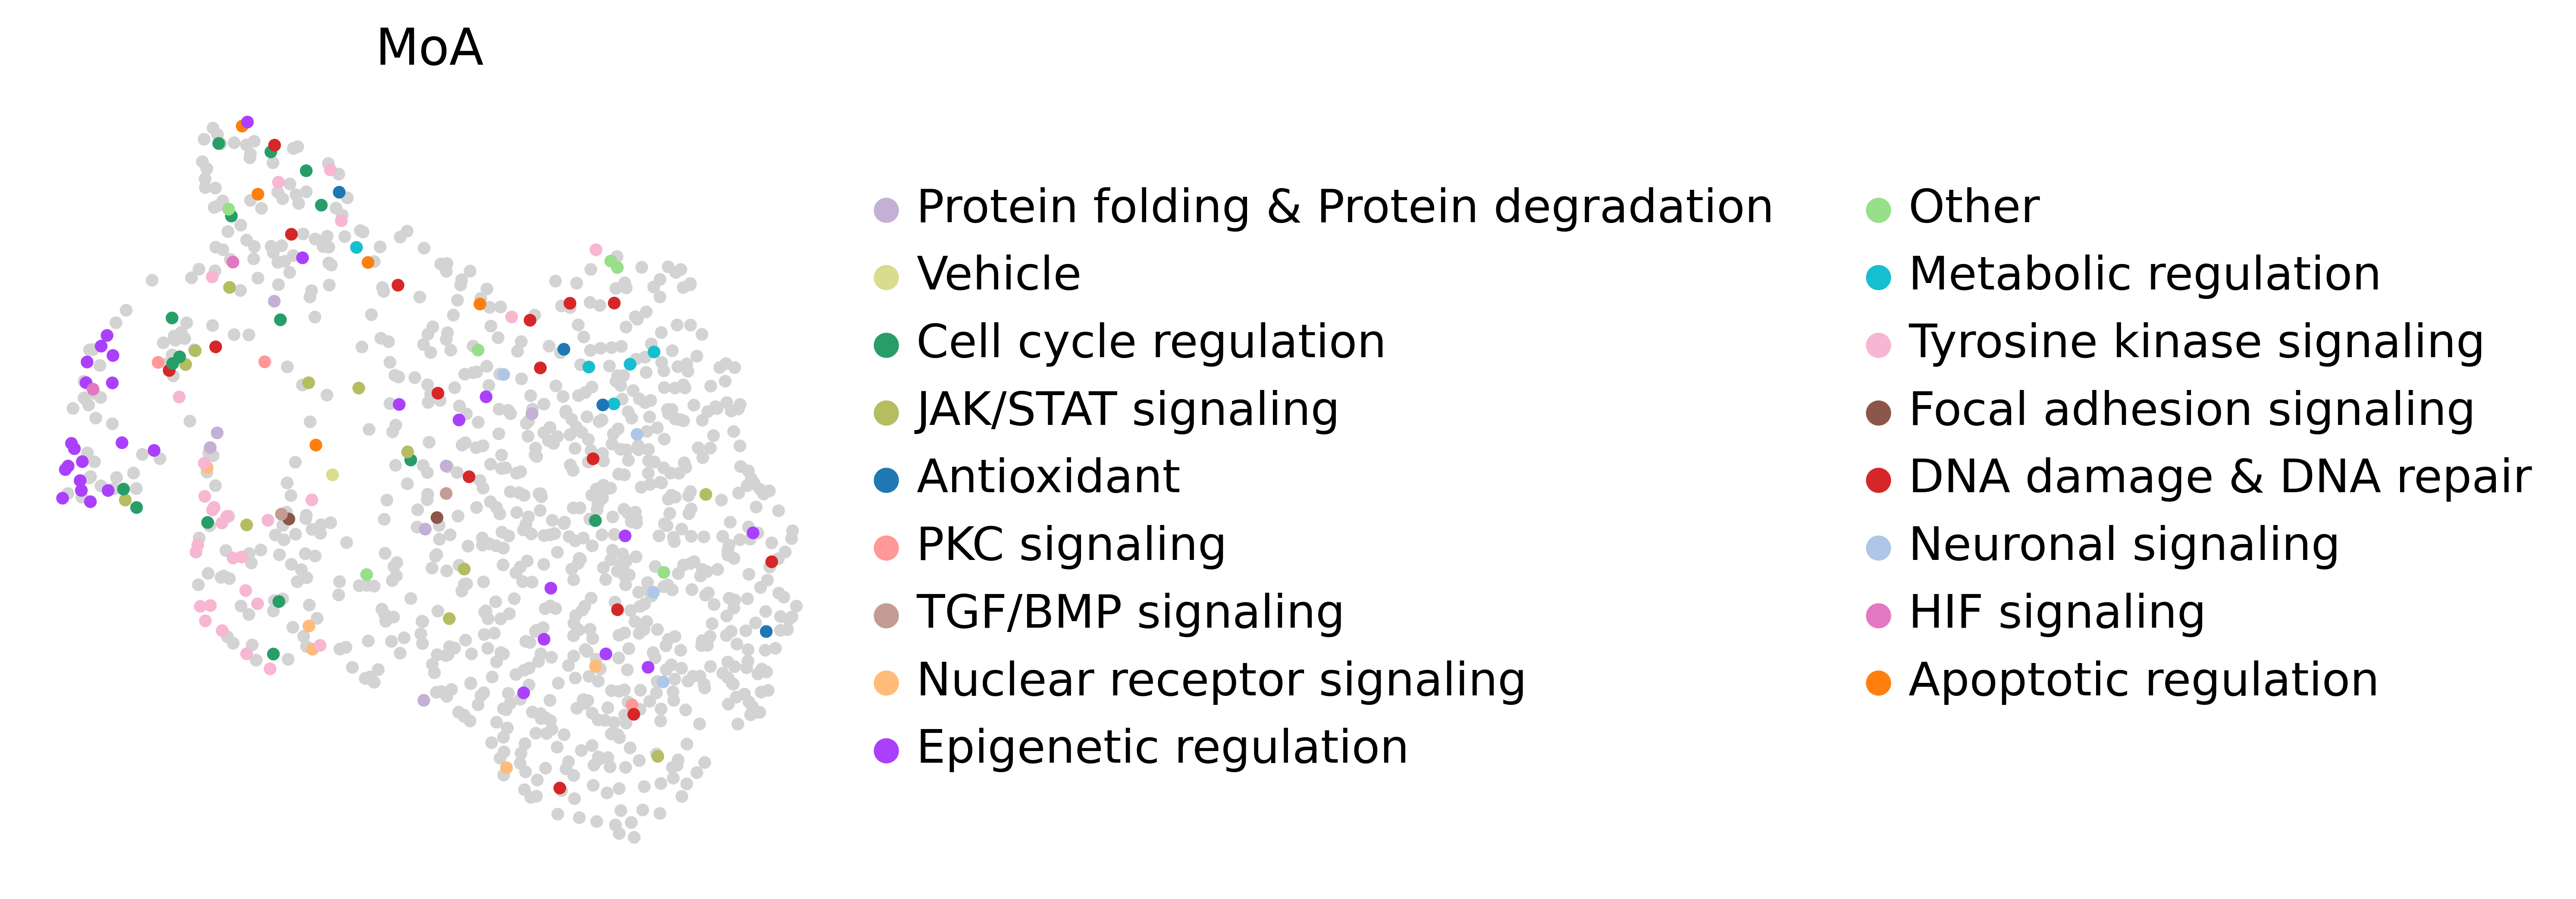

In [36]:
sc.pl.umap(perts_anndata, color='MoA', size=50, groups=set(sciplex.obs.pathway_level_1.unique()))

In [66]:
MoAs = ['Epigenetic regulation', 'Tyrosine kinase signaling', 'Cell cycle regulation']
cmpds = sciplex[sciplex.obs.pathway_level_1.isin(MoAs)].obs.cond_new.unique()
cmpds = list(np.random.choice(cmpds, size=50, replace=False))
cmpds += ['Dacinostat', 'UNC0379', 'Pracinostat', 'Sirtinol',
    'TMP195', 'GSK', 'PCI-34051', 'Tacedinaline', 'Trametinib',
    'EED226', 'Tucidinostat', 'CUDC-907', 'Selisistat',
    'Anacardic', 'Azacitidine', 'Belinostat',
    'Tazemetostat', 'SRT3025', 'Trichostatin', 'SRT1720', 'Panobinostat', 'UNC0631',
    'A-366', 'Divalproex']
print(cmpds)
cmpds = [dict(zip(sciplex.obs.cond_new, sciplex.obs.pert_iname))[c] for c in set(cmpds) if c != 'Vehicle']

['PFI-1', 'Vandetanib', 'AMG-900', 'TGX-221', 'SRT3025', 'GSK-LSD1', 'Danusertib', 'MLN8054', 'Tacedinaline', 'Pracinostat', 'GSK1070916', 'Barasertib', 'SRT2104', 'Resminostat', 'RG108', 'Decitabine', 'BMS-536924', 'Flavopiridol', 'Tazemetostat', 'BMS-265246', 'PD98059', 'Cediranib', 'Crizotinib', 'Dasatinib', 'Givinostat', 'Tie2', 'PCI-34051', 'Tubastatin', 'Quisinostat', 'BMS-754807', 'Divalproex', 'Aurora', 'Azacitidine', 'JQ1', 'UNC0379', 'TMP195', 'CYC116', 'Droxinostat', 'CUDC-101', 'Trichostatin', 'Mocetinostat', 'Bosutinib', 'M344', 'UNC1999', 'Tozasertib', 'ZM', 'Sorafenib', 'MK-5108', 'SRT1720', 'UNC0631', 'Dacinostat', 'UNC0379', 'Pracinostat', 'Sirtinol', 'TMP195', 'GSK', 'PCI-34051', 'Tacedinaline', 'Trametinib', 'EED226', 'Tucidinostat', 'CUDC-907', 'Selisistat', 'Anacardic', 'Azacitidine', 'Belinostat', 'Tazemetostat', 'SRT3025', 'Trichostatin', 'SRT1720', 'Panobinostat', 'UNC0631', 'A-366', 'Divalproex']


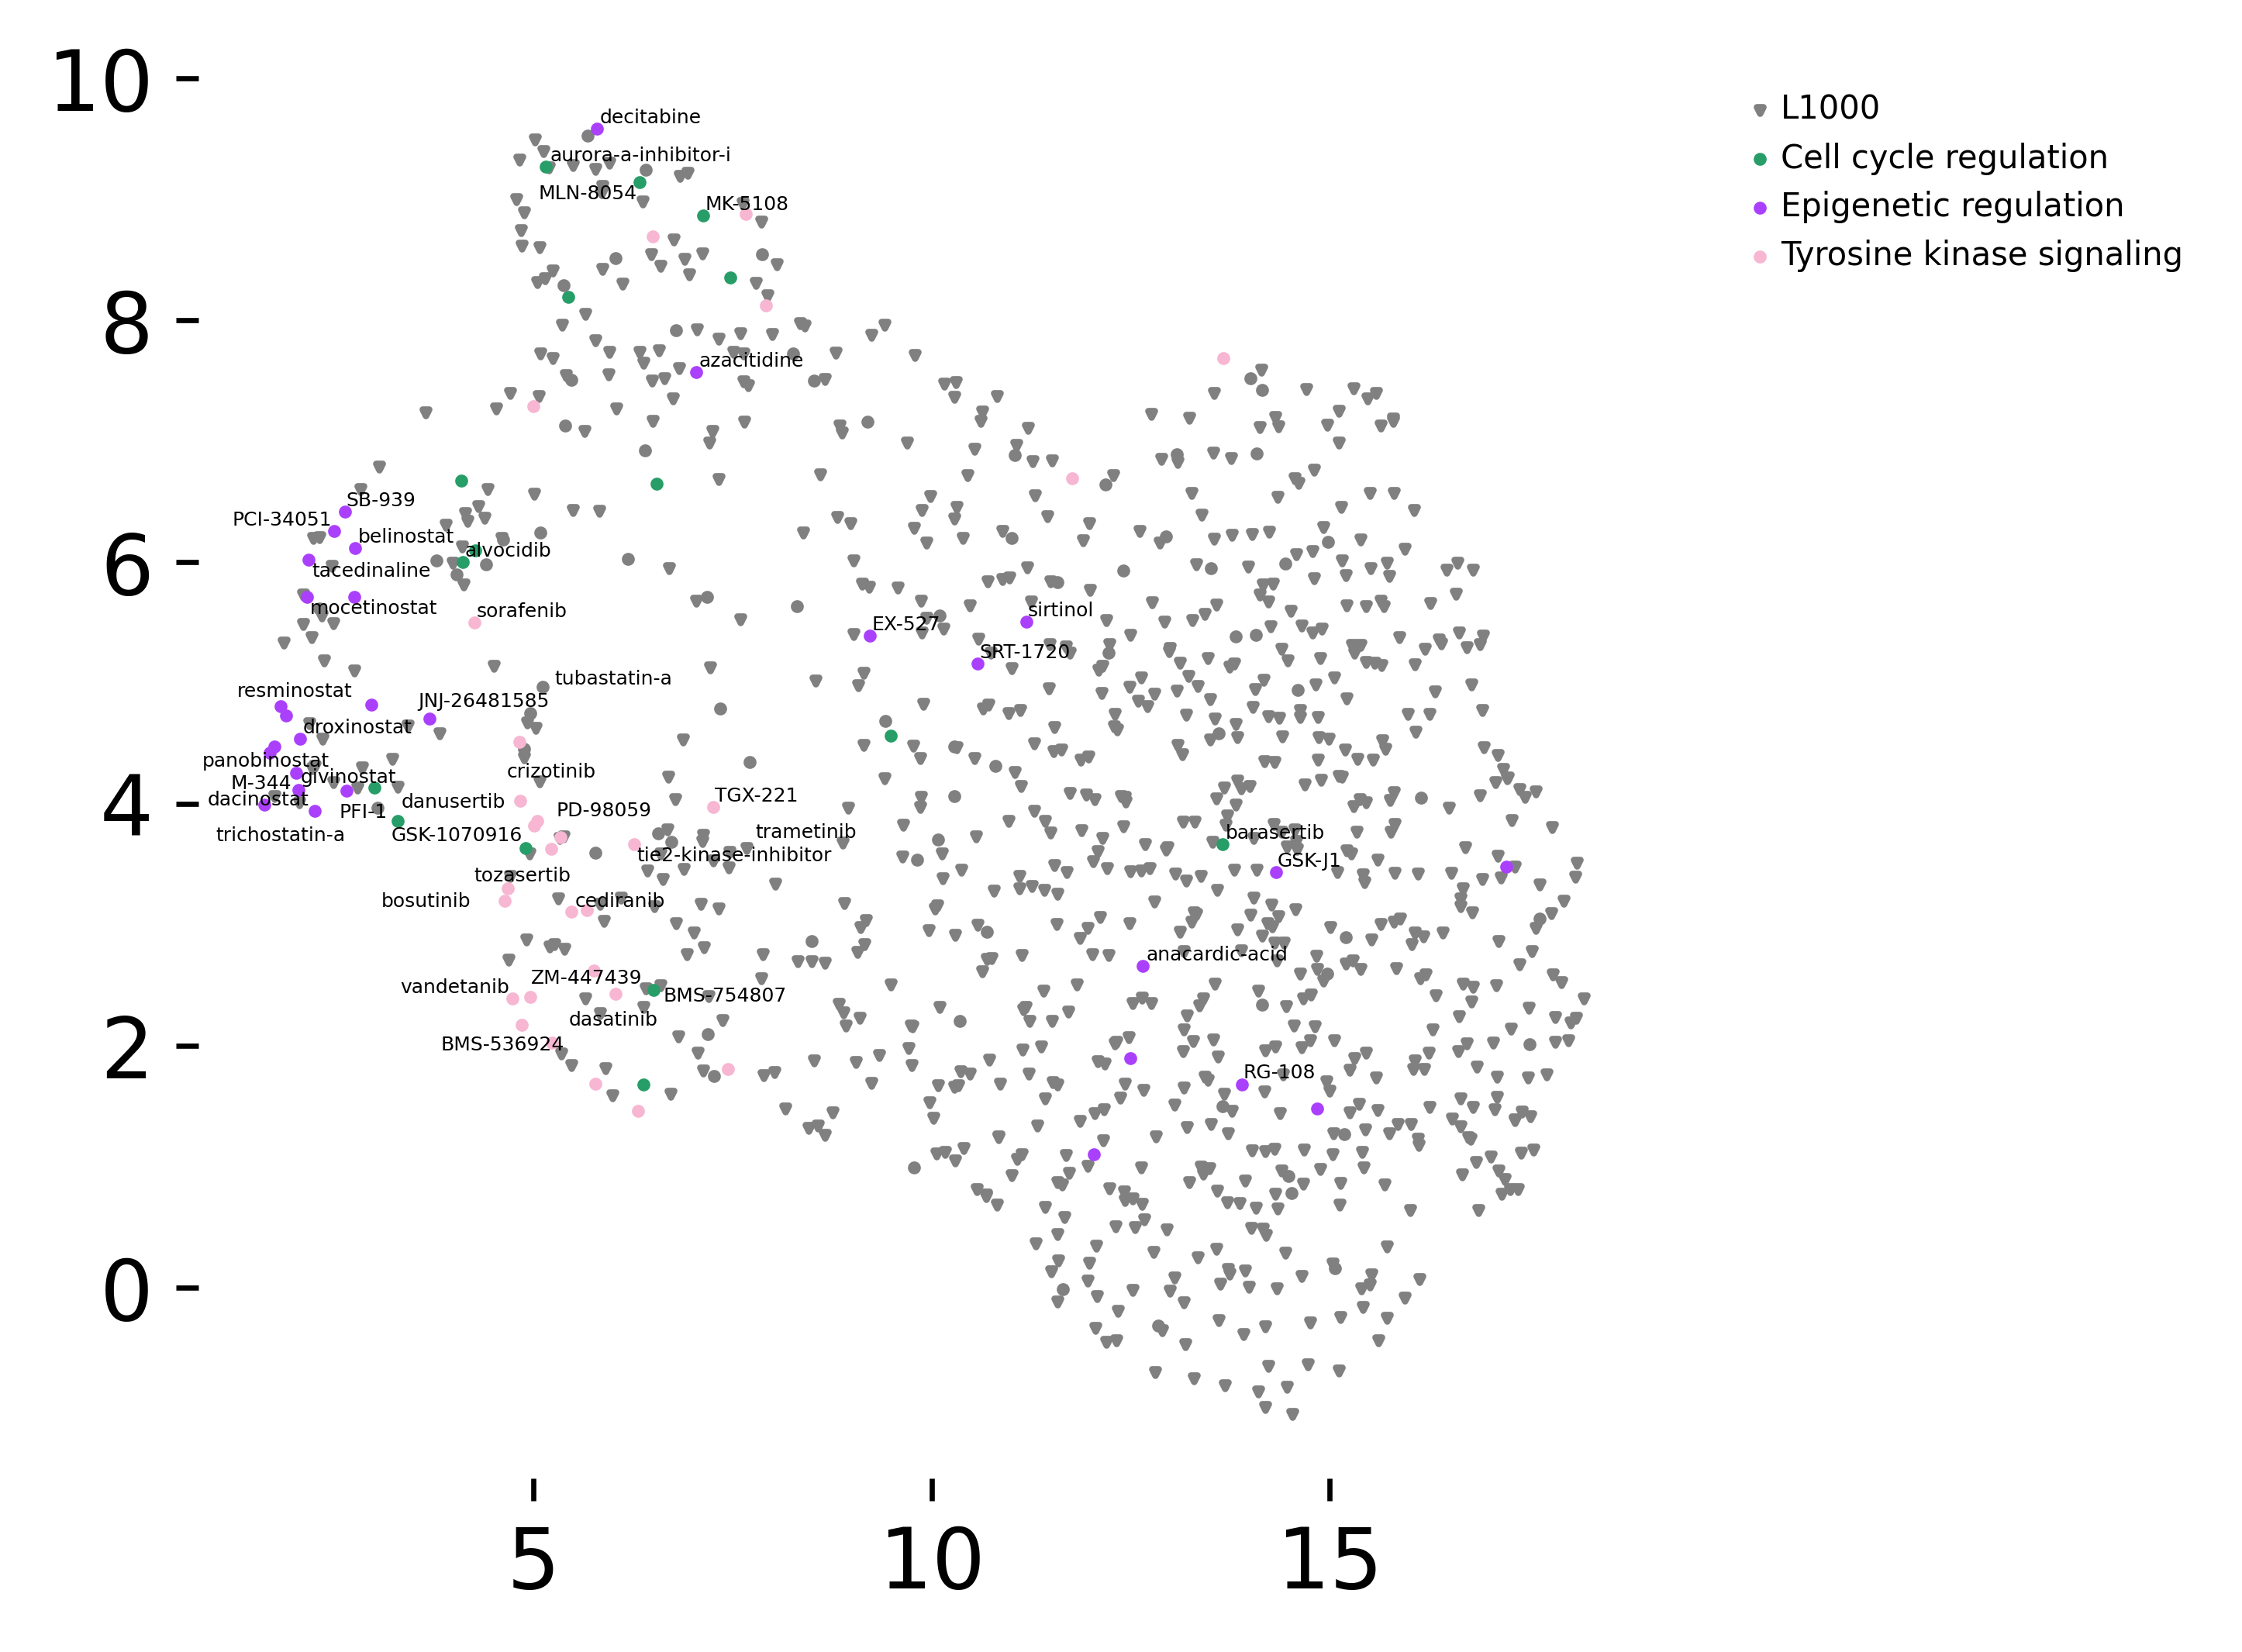

In [67]:
from adjustText import adjust_text

# L1000 dots
pa_subset = perts_anndata[~perts_anndata.obs.MoA.isin(list(set(sciplex.obs.pathway_level_1.unique())))]
x = pa_subset.obsm['X_umap'].T[0]
y = pa_subset.obsm['X_umap'].T[1]
plt.scatter(x, y, label='L1000', color='grey', s=1, marker='v')

# plot colored dots
pa_subset = perts_anndata[perts_anndata.obs.MoA.isin(list(set(sciplex.obs.pathway_level_1.unique())))]
for i, moa in enumerate(pa_subset.obs.MoA.cat.categories):
    subset = pa_subset[pa_subset.obs.MoA == moa].copy()
    x = subset.obsm['X_umap'].T[0]
    y = subset.obsm['X_umap'].T[1]
    if moa in MoAs:
        plt.scatter(x, y, label=moa, color=pa_subset.uns['MoA_colors'][i], s=1, marker='o')
    else:
        plt.scatter(x, y, label='', color='grey', s=1, marker='o')

# plot texts
x = perts_anndata.obsm['X_umap'].T[0]
y = perts_anndata.obsm['X_umap'].T[1]
texts = [plt.text(x[i], y[i], f'{perts_anndata.obs.condition.values[i]}', size=3) for i in range(len(x)) if perts_anndata.obs.condition.values[i] in cmpds]
adjust_text(texts)
plt.grid(b=None)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=5, frameon=False)
# plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')
plt.box(False)
plt.show();

Cell line embedding.

In [68]:
# compert_plots = CompertVisuals(compert_api, fileprefix=None)

In [73]:
covars_anndata = compert_api.get_covars_embeddings()
# covars_anndata.obs['MoA'] = covars_anndata.obs.condition.map(
#     dict(zip(list(sciplex.obs.pert_iname.values) + ['DMSO'], list(sciplex.obs.pathway_level_1.values) + ['Vehicle'])))

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [75]:
sc.tl.pca(covars_anndata)
sc.pp.neighbors(covars_anndata, n_neighbors=6, metric='cosine', n_pcs=7)
sc.tl.umap(covars_anndata)

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


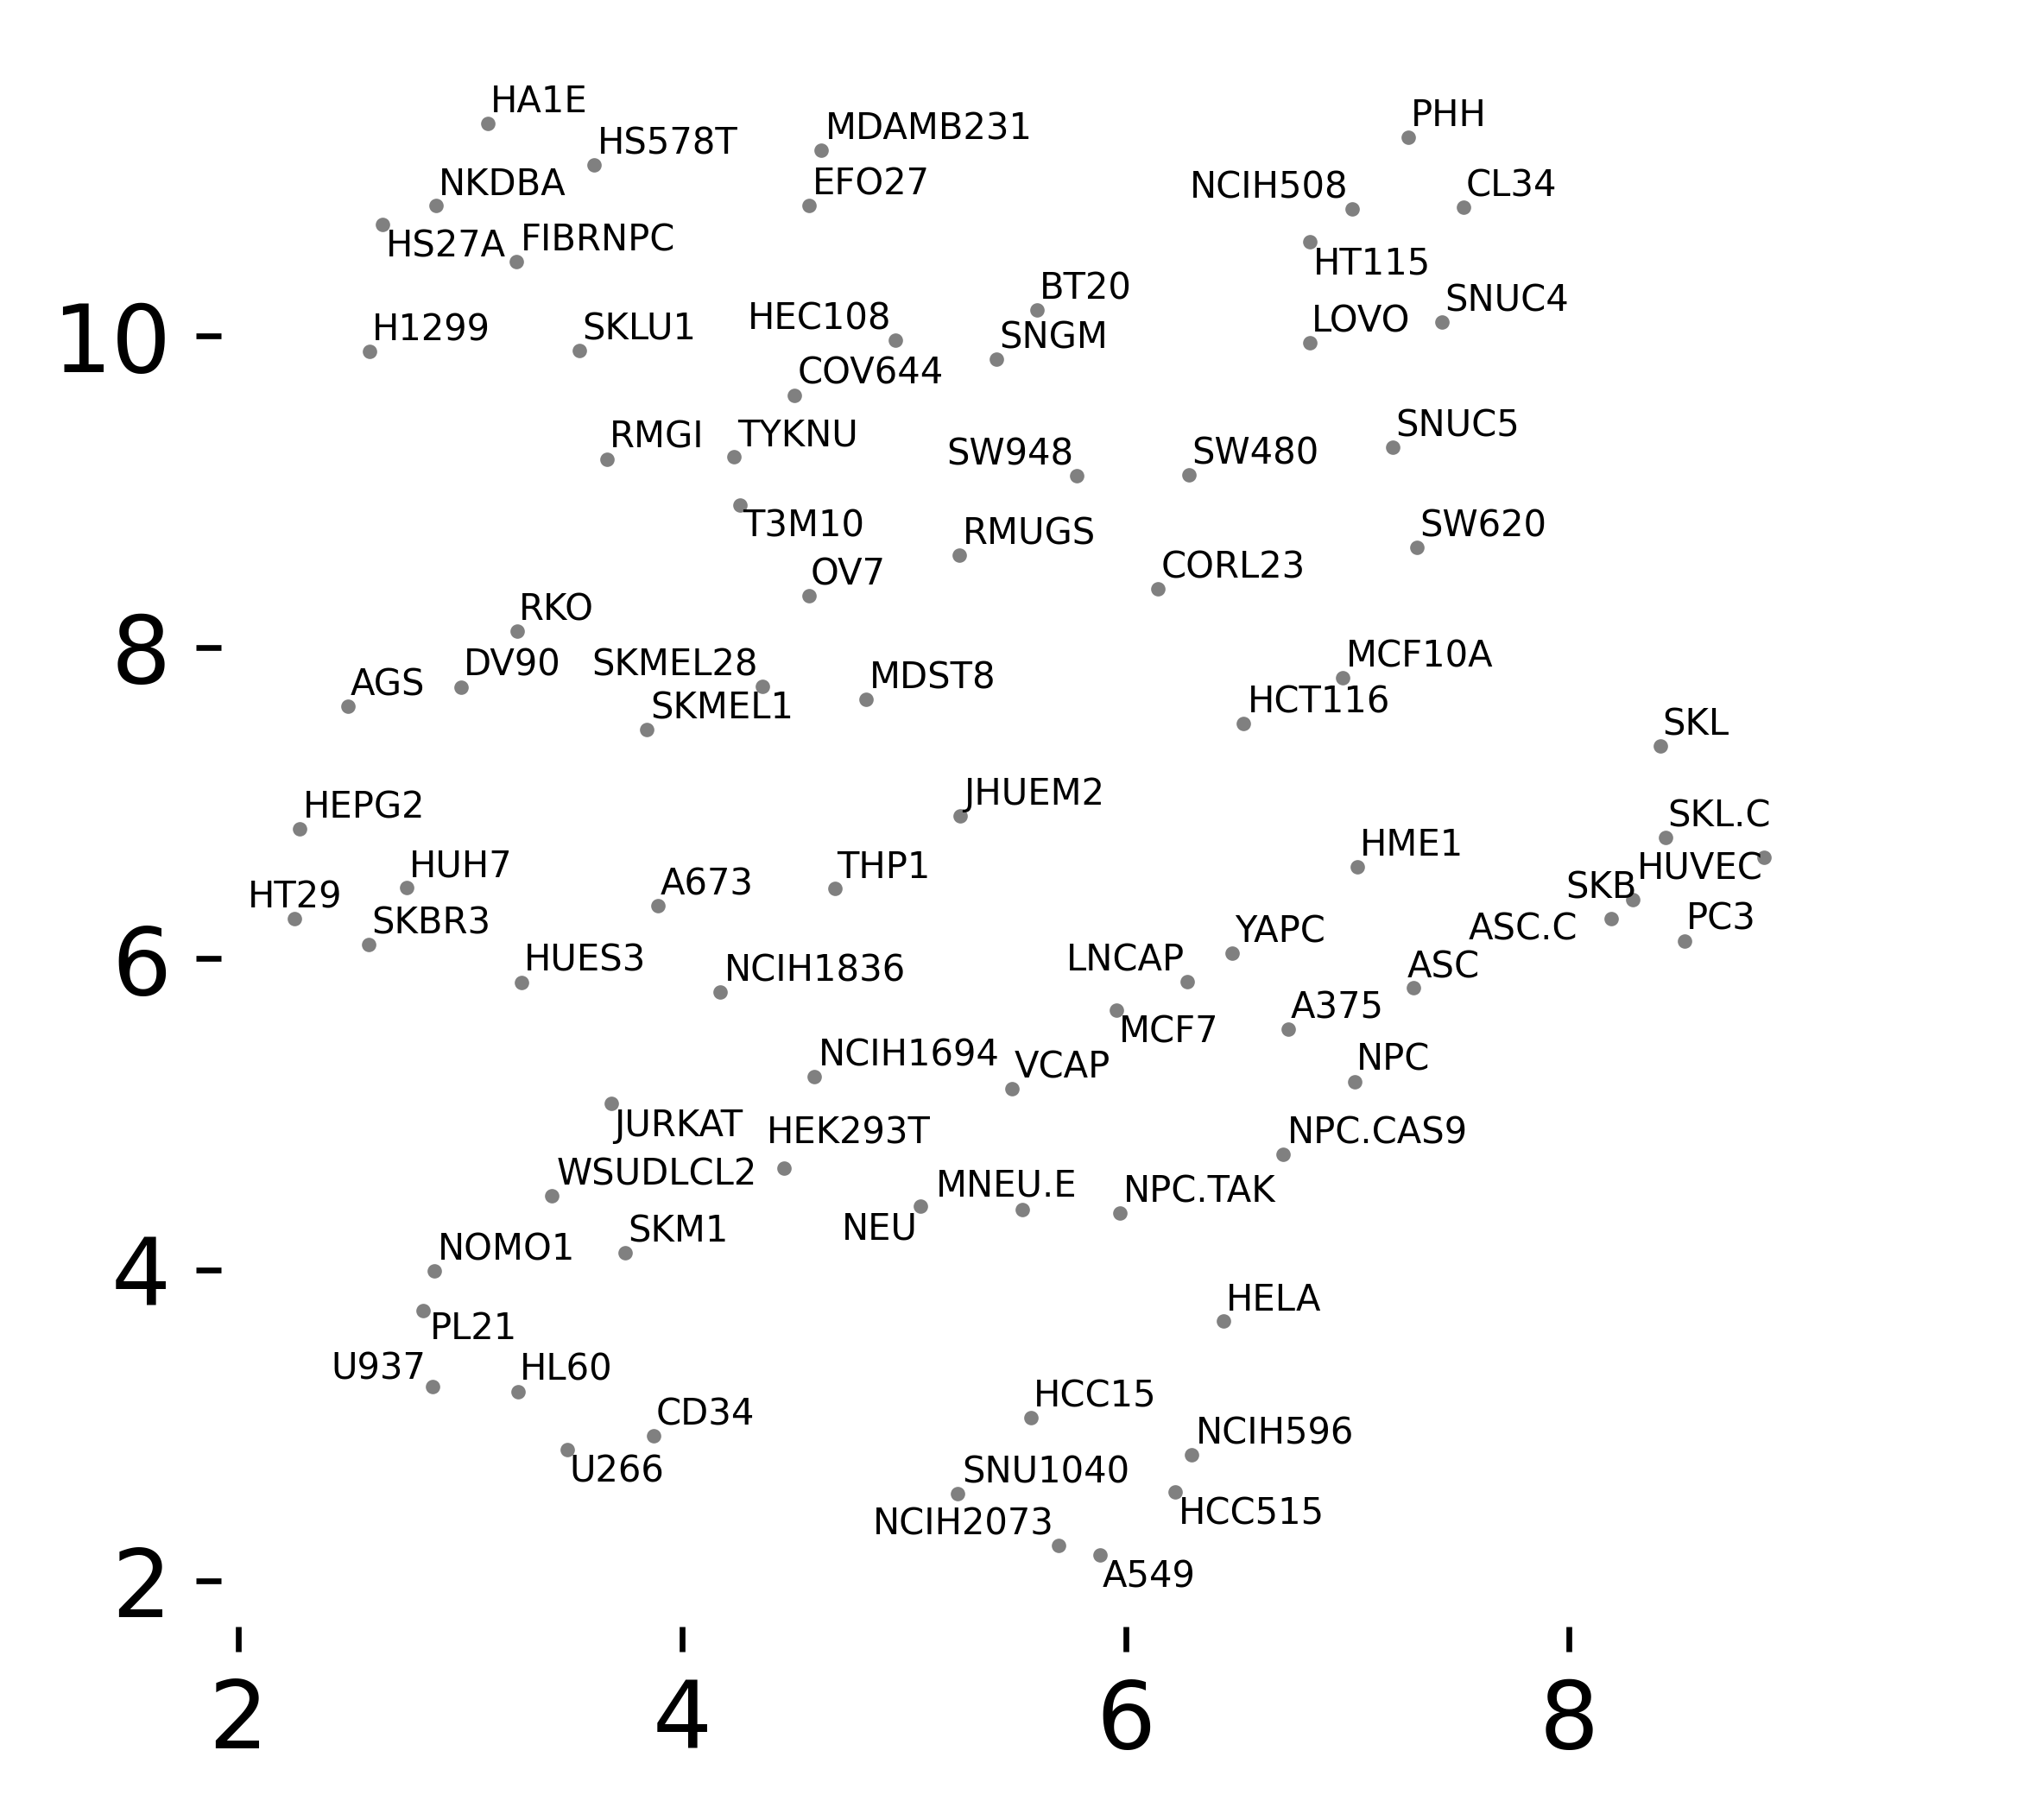

In [85]:
# plot texts
x = covars_anndata.obsm['X_umap'].T[0]
y = covars_anndata.obsm['X_umap'].T[1]
plt.scatter(x, y, label='', color='grey', s=1, marker='o')
texts = [plt.text(x[i], y[i], f'{covars_anndata.obs.cell_type.values[i]}', size=5) for i in range(len(x))]
adjust_text(texts)
plt.grid(b=None)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=5, frameon=False)
# plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')
plt.box(False)
plt.show();

In [81]:
# compert_plots.plot_latent_embeddings(
#     compert_api.emb_covars, kind='covariates', #labels=compert_api.unique_сovars,
#     titlename='cell line embeddings', show_text=False)